In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile, Aer, execute, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from math import pi
from numpy import binary_repr
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
in1 = int(input("Enter integer 1: "))
in2 = int(input("Enter integer 2: "))

bin1 = '{0:{fill}3b}'.format(in1, fill='0')
bin2 = '{0:{fill}3b}'.format(in2, fill='0')
print("Binary Representation of integer 1: ", bin1)
print("Binary Representation of integer 2: ", bin2)


Enter integer 1:  3
Enter integer 2:  7


Binary Representation of integer 1:  011
Binary Representation of integer 2:  111


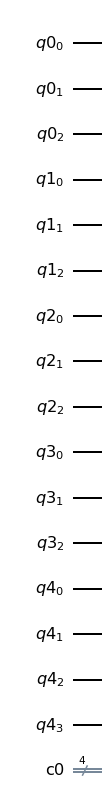

In [5]:
length1 = len(bin1)
length2 = len(bin2)

#n is for declaring quantum registers
if length1 > length2:
    n = length1
else:
    n = length2

firstNum = QuantumRegister(n)
secondNum = QuantumRegister(n)
carryBit = QuantumRegister(n)
supportBit = QuantumRegister(3)
resultBit = QuantumRegister(n + 1)
classicalBit = ClassicalRegister(n + 1)

#circuit including all of these:

qc = QuantumCircuit(firstNum, secondNum, carryBit, supportBit, resultBit, classicalBit)
qc.draw('mpl')

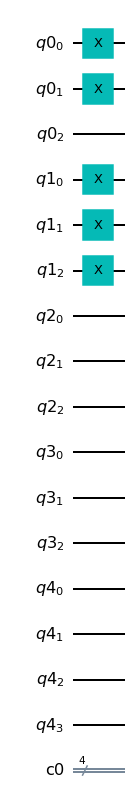

In [6]:
for i in range(length1):
    if bin1[i] == "1":
        qc.x(firstNum[length1 - (i + 1)])
        
for i in range(length2):
    if bin2[i] == "1":
        qc.x(secondNum[length2 - (i + 1)])

qc.draw('mpl')

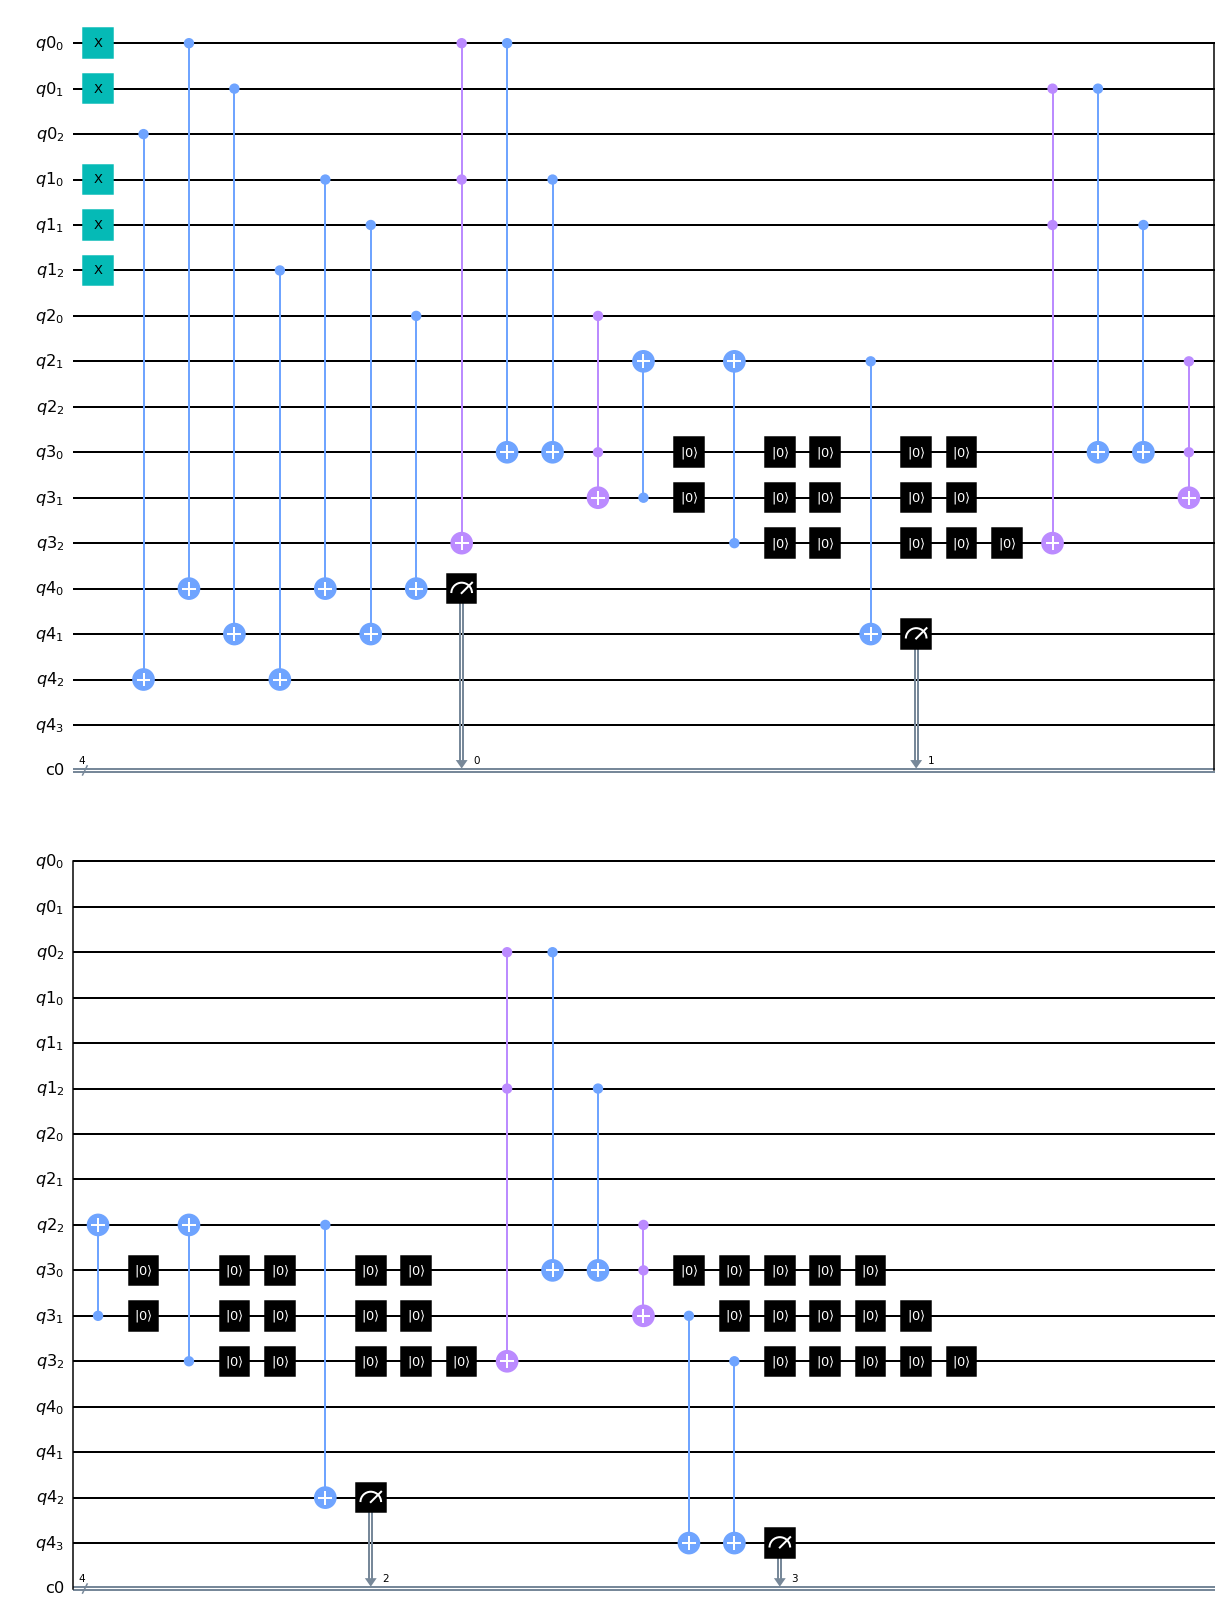

In [7]:
#Ripple Carry Adder:

for i in range(n - 1):
    
    qc.cx(firstNum[i], resultBit[i])
    qc.cx(secondNum[i], resultBit[i])
    qc.cx(carryBit[i], resultBit[i])
    
    #ccx to and the inputs to qubit 3
    qc.ccx(firstNum[i], secondNum[i], supportBit[2])
    qc.cx(firstNum[i], supportBit[0])
    qc.cx(secondNum[i], supportBit[0])
    
    qc.ccx(supportBit[0], carryBit[i], supportBit[1])
    qc.cx(supportBit[1], carryBit[i+1])
    qc.cx(supportBit[2], carryBit[i+1])
    
    qc.reset([9]*5)
    qc.reset([10]*5)
    qc.reset([11]*5)
    
# #Sum = (firstNum xor secondNum) xor cin
qc.cx(firstNum[n - 1], resultBit[n - 1])
qc.cx(secondNum[n - 1], resultBit[n - 1])

qc.cx(carryBit[n - 1], resultBit[n - 1])

qc.ccx(firstNum[n - 1], secondNum[n - 1], supportBit[2])
qc.cx(firstNum[n - 1], supportBit[0])
qc.cx(secondNum[n - 1], supportBit[0])

qc.ccx(supportBit[0], carryBit[n - 1], supportBit[1])

qc.cx(supportBit[1], resultBit[n])
qc.cx(supportBit[2], resultBit[n])

qc.reset([9]*5)
qc.reset([10]*5)
qc.reset([11]*5)

for i in range(n + 1):
    qc.measure(resultBit[i], classicalBit[i])
qc.draw('mpl')

In [8]:
num_shots = 100
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
job_stats = job.result().get_counts()

In [9]:
print(job_stats)

{'1010': 100}


In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_qasm_simulator')
counts = execute(qc, backend, shots=100).result().get_counts()
print(counts)

ibmqfactory.load_account:WARNING:2022-10-01 11:24:18,650: Credentials are already in use. The existing account in the session will be replaced.


{'1010': 100}


In [11]:
#QFT functions that will be used in Multiplication

def executeQFT(qc, reg, n, pie):  
    qc.h(reg[n])    
    for i in range(0, n):
        qc.cp(pie/float(2**(i+1)), reg[n-(i+1)], reg[n])    

def inverseQFT(qc, reg, n, pie):
    for i in range(n):
        qc.cp(-1*pie/float(2**(n-i)), reg[i], reg[n])
    qc.h(reg[n])
    
def initQubits(str, qc, reg, n):
    for i in range(n):
        if str[i] == "1":
            qc.x(reg[n-(i+1)])

def printResult(bin1, bin2, qc,result, classicalBit, n, operator):
    for i in range(n+1):
        qc.measure(result[i], classicalBit[i])
        
   
    num_shots = 100
    job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
    
    job_stats = job.result().get_counts()
    for key, value in job_stats.items():
        res = key
        prob = value
    print(f'\n{in1} {operator} {in2} = {int(res, 2)}')
        
def evolveQFTStateSum(qc, reg_a, reg_b, n, pie):
    l = len(reg_b)
    for i in range(n+1):
        if (n - i) > l - 1:
            pass
        else:
            qc.cp(pie/float(2**(i)), reg_b[n-i], reg_a[n])

In [12]:
def multiply(firstNum, secondDec, result, qc):
    pie = pi
    n = len(firstNum) -1
   
    for i in range(n+1):
        executeQFT(qc, result, n-i, pie)
    
    for j in range(secondDec):
        for i in range(n+1):
            evolveQFTStateSum(qc, result, firstNum, n-i, pie)

    # Compute the inverse Fourier transform of register a
    for i in range(n+1):
        inverseQFT(qc, result, i, pie)

Enter integer 1:  10
Enter integer 2:  11


Binary Representation of integer 1:  1010
Binary Representation of integer 2:  1011

10 * 11 = 110


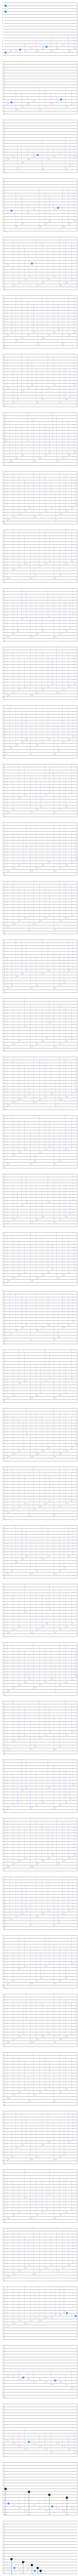

In [14]:
in1 = int(input("Enter integer 1: "))
in2 = int(input("Enter integer 2: "))

bin1 = '{0:{fill}3b}'.format(in1, fill='0')
bin2 = '{0:{fill}3b}'.format(in2, fill='0')
print("Binary Representation of integer 1: ", bin1)
print("Binary Representation of integer 2: ", bin2)

firstin1 = in1
secondin2 = in2

l1 = len(bin1)
l2 = len(bin2)

bin1 = ("0")*(l2) + bin1
n = l1 + l2

a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")
accumulator = QuantumRegister(n+1, "accumulator")     
cl = ClassicalRegister(n+1, "cl")

qc = QuantumCircuit(a, b, cl, name="qc")
# Flip the corresponding qubit in register a if a bit in the string first is a 1
initQubits(bin1, qc, a, n)

multiply(a,secondin2,b,qc)
operator = '*'
printResult(bin1, bin2, qc, b, cl, n, operator)
qc.draw('mpl')

In [17]:
### Only takes small input let say till 15
### I think it can be optimized and I'll try to udate the code in near future